# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

C:\Users\Brenand\miniconda3\envs\mpdl\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y-y_pred))
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)/y.shape[0]
    return 0.5 * np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com média 0 e stddev=sqrt(2.0/(out+inp))
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w >0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization

In [11]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, 
                 dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, 
                 is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, 
                 momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, 
            batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)
                
                loss_val = self.cost_func(y_val, self.predict(x_val))
                if loss_val < self._best_loss:
                    self._best_model, self._best_loss = self.layers, loss_val
                    self.waiting = 0
                else:
                    self.waiting += 1
                    if self.waiting >= self.patience:
                        self.layers = self._best_model
                        return
                    
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in 
                self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val: {5:.8f}".format(epoch, epochs, 
                loss_train, loss_reg, loss_train + loss_reg, loss_val))
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0 - 
            current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, 
                derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [13]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [14]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val: 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val: 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val: 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val: 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val: 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val: 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val: 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val: 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val: 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val: 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.201

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [15]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


-1.0 0.9999999999999991


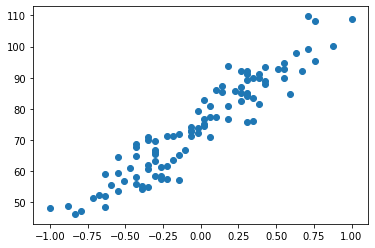

In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss_train: 2745.79187898 + 0.00000000 = 2745.79187898 loss_val: 2745.79187898
epoch:  100/1000 loss_train: 439.59506858 + 0.00000000 = 439.59506858 loss_val: 439.59506858
epoch:  200/1000 loss_train: 111.96176043 + 0.00000000 = 111.96176043 loss_val: 111.96176043
epoch:  300/1000 loss_train: 55.05551724 + 0.00000000 = 55.05551724 loss_val: 55.05551724
epoch:  400/1000 loss_train: 38.45778544 + 0.00000000 = 38.45778544 loss_val: 38.45778544
epoch:  500/1000 loss_train: 30.05824282 + 0.00000000 = 30.05824282 loss_val: 30.05824282
epoch:  600/1000 loss_train: 24.68432729 + 0.00000000 = 24.68432729 loss_val: 24.68432729
epoch:  700/1000 loss_train: 21.04184171 + 0.00000000 = 21.04184171 loss_val: 21.04184171
epoch:  800/1000 loss_train: 18.54353295 + 0.00000000 = 18.54353295 loss_val: 18.54353295
epoch:  900/1000 loss_train: 16.82599911 + 0.00000000 = 16.82599911 loss_val: 16.82599911
epoch: 1000/1000 loss_train: 15.64469535 + 0.00000000 = 15.64469535 loss_val: 15.6446953

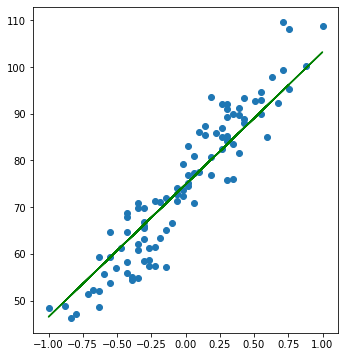

In [17]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [18]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [19]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [20]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 12933.41663973 + 0.00000000 = 12933.41663973 loss_val: 12933.41663973
epoch:  200/2000 loss_train: 240.63595507 + 0.00000000 = 240.63595507 loss_val: 240.63595507
epoch:  400/2000 loss_train: 39.70709068 + 0.00000000 = 39.70709068 loss_val: 39.70709068
epoch:  600/2000 loss_train: 15.92259310 + 0.00000000 = 15.92259310 loss_val: 15.92259310
epoch:  800/2000 loss_train: 11.57274286 + 0.00000000 = 11.57274286 loss_val: 11.57274286
epoch: 1000/2000 loss_train: 10.09420070 + 0.00000000 = 10.09420070 loss_val: 10.09420070
epoch: 1200/2000 loss_train: 9.13592498 + 0.00000000 = 9.13592498 loss_val: 9.13592498
epoch: 1400/2000 loss_train: 8.34871771 + 0.00000000 = 8.34871771 loss_val: 8.34871771
epoch: 1600/2000 loss_train: 7.67000581 + 0.00000000 = 7.67000581 loss_val: 7.67000581
epoch: 1800/2000 loss_train: 7.07972108 + 0.00000000 = 7.07972108 loss_val: 7.07972108
epoch: 2000/2000 loss_train: 6.56534620 + 0.00000000 = 6.56534620 loss_val: 6.56534620
[[18.40922224

### Regressão Quadrática

In [64]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


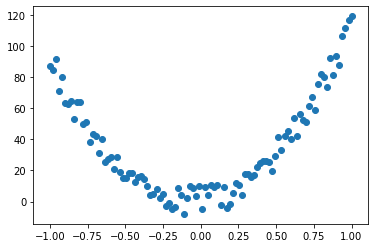

In [65]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/2000 loss_train: 1096.85560304 + 0.00000000 = 1096.85560304 loss_val: 1096.85560304
epoch:  100/2000 loss_train: 195.89917146 + 0.00000000 = 195.89917146 loss_val: 195.89917146
epoch:  200/2000 loss_train: 46.27847067 + 0.00000000 = 46.27847067 loss_val: 46.27847067
epoch:  300/2000 loss_train: 26.70529269 + 0.00000000 = 26.70529269 loss_val: 26.70529269
epoch:  400/2000 loss_train: 21.71161014 + 0.00000000 = 21.71161014 loss_val: 21.71161014
epoch:  500/2000 loss_train: 19.49344795 + 0.00000000 = 19.49344795 loss_val: 19.49344795
epoch:  600/2000 loss_train: 18.16158834 + 0.00000000 = 18.16158834 loss_val: 18.16158834
epoch:  700/2000 loss_train: 17.28197832 + 0.00000000 = 17.28197832 loss_val: 17.28197832
epoch:  800/2000 loss_train: 16.67569599 + 0.00000000 = 16.67569599 loss_val: 16.67569599
epoch:  900/2000 loss_train: 16.23325672 + 0.00000000 = 16.23325672 loss_val: 16.23325672
epoch: 1000/2000 loss_train: 16.35539266 + 0.00000000 = 16.35539266 loss_val: 16.35539266
e

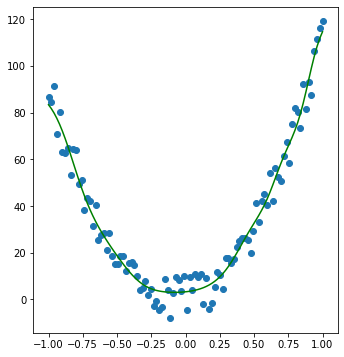

In [67]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=2000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [68]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


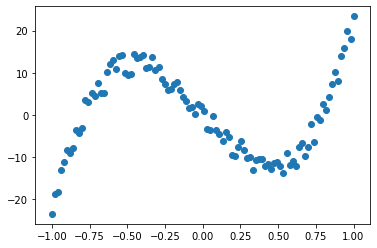

In [69]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 53.15544230 + 0.00000000 = 53.15544230 loss_val: 53.15544230
epoch:  100/1000 loss_train: 30.12417005 + 0.00000000 = 30.12417005 loss_val: 30.12417005
epoch:  200/1000 loss_train: 13.73962478 + 0.00000000 = 13.73962478 loss_val: 13.73962478
epoch:  300/1000 loss_train: 7.14174645 + 0.00000000 = 7.14174645 loss_val: 7.14174645
epoch:  400/1000 loss_train: 4.48544079 + 0.00000000 = 4.48544079 loss_val: 4.48544079
epoch:  500/1000 loss_train: 3.37064621 + 0.00000000 = 3.37064621 loss_val: 3.37064621
epoch:  600/1000 loss_train: 2.80569241 + 0.00000000 = 2.80569241 loss_val: 2.80569241
epoch:  700/1000 loss_train: 2.45431423 + 0.00000000 = 2.45431423 loss_val: 2.45431423
epoch:  800/1000 loss_train: 2.21023563 + 0.00000000 = 2.21023563 loss_val: 2.21023563
epoch:  900/1000 loss_train: 2.02857595 + 0.00000000 = 2.02857595 loss_val: 2.02857595
epoch: 1000/1000 loss_train: 1.89223243 + 0.00000000 = 1.89223243 loss_val: 1.89223243


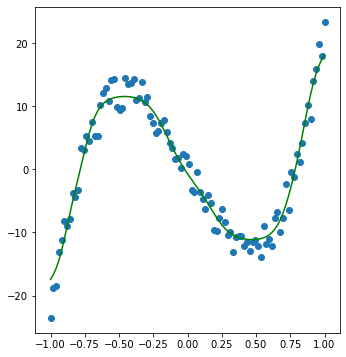

In [70]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [71]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


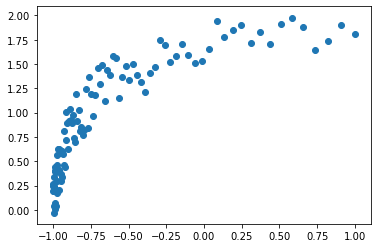

In [72]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/1000 loss_train: 1.75045737 + 0.00000000 = 1.75045737 loss_val: 1.75045737
epoch:  100/1000 loss_train: 0.05852215 + 0.00000000 = 0.05852215 loss_val: 0.05852215
epoch:  200/1000 loss_train: 0.03331253 + 0.00000000 = 0.03331253 loss_val: 0.03331253
epoch:  300/1000 loss_train: 0.02791200 + 0.00000000 = 0.02791200 loss_val: 0.02791200
epoch:  400/1000 loss_train: 0.02597083 + 0.00000000 = 0.02597083 loss_val: 0.02597083
epoch:  500/1000 loss_train: 0.02470966 + 0.00000000 = 0.02470966 loss_val: 0.02470966
epoch:  600/1000 loss_train: 0.02369293 + 0.00000000 = 0.02369293 loss_val: 0.02369293
epoch:  700/1000 loss_train: 0.02283112 + 0.00000000 = 0.02283112 loss_val: 0.02283112
epoch:  800/1000 loss_train: 0.02208846 + 0.00000000 = 0.02208846 loss_val: 0.02208846
epoch:  900/1000 loss_train: 0.02144179 + 0.00000000 = 0.02144179 loss_val: 0.02144179
epoch: 1000/1000 loss_train: 0.02087396 + 0.00000000 = 0.02087396 loss_val: 0.02087396


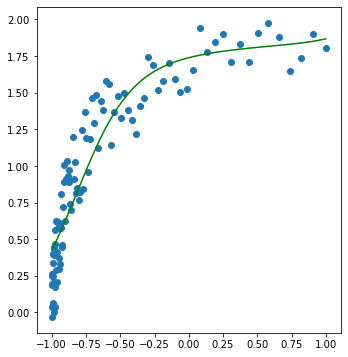

In [76]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [77]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


[-1.] [1.]


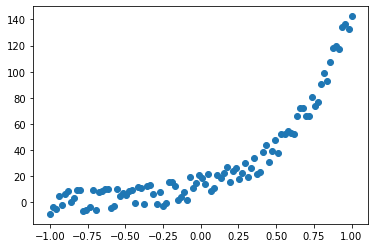

In [78]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))
plt.scatter(x, y)

epoch:    0/2000 loss_train: 1150.68936430 + 0.00000000 = 1150.68936430 loss_val: 1150.68936430
epoch:  100/2000 loss_train: 77.21930485 + 0.00000000 = 77.21930485 loss_val: 77.21930485
epoch:  200/2000 loss_train: 48.71858738 + 0.00000000 = 48.71858738 loss_val: 48.71858738
epoch:  300/2000 loss_train: 34.76383108 + 0.00000000 = 34.76383108 loss_val: 34.76383108
epoch:  400/2000 loss_train: 25.46789895 + 0.00000000 = 25.46789895 loss_val: 25.46789895
epoch:  500/2000 loss_train: 22.26943189 + 0.00000000 = 22.26943189 loss_val: 22.26943189
epoch:  600/2000 loss_train: 20.71667379 + 0.00000000 = 20.71667379 loss_val: 20.71667379
epoch:  700/2000 loss_train: 20.03689875 + 0.00000000 = 20.03689875 loss_val: 20.03689875
epoch:  800/2000 loss_train: 19.55622985 + 0.00000000 = 19.55622985 loss_val: 19.55622985
epoch:  900/2000 loss_train: 19.09041758 + 0.00000000 = 19.09041758 loss_val: 19.09041758
epoch: 1000/2000 loss_train: 18.90672818 + 0.00000000 = 18.90672818 loss_val: 18.90672818
epoc

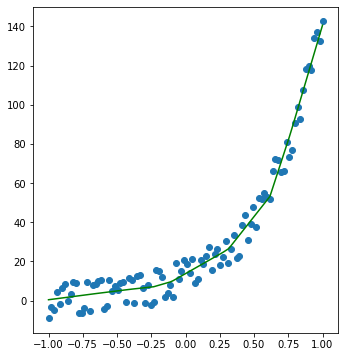

In [82]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=2000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [83]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 loss_train: 0.90085811 + 0.01671336 = 0.91757148 loss_val: 0.90085811
epoch: 1000/5000 loss_train: 0.05525238 + 0.12546100 = 0.18071338 loss_val: 0.05525238
epoch: 2000/5000 loss_train: 0.05203789 + 0.12856725 = 0.18060514 loss_val: 0.05203789
epoch: 3000/5000 loss_train: 0.05183383 + 0.12877086 = 0.18060468 loss_val: 0.05183383
epoch: 4000/5000 loss_train: 0.05182007 + 0.12878461 = 0.18060468 loss_val: 0.05182007
epoch: 5000/5000 loss_train: 0.05181914 + 0.12878554 = 0.18060468 loss_val: 0.05181914
[[5.15142175 5.15142175]] [[-8.1022515]]
Predições:
[[3.02764796e-04]
 [4.96973102e-02]
 [4.96973102e-02]
 [9.00302661e-01]]
Acurácia: 100.00%


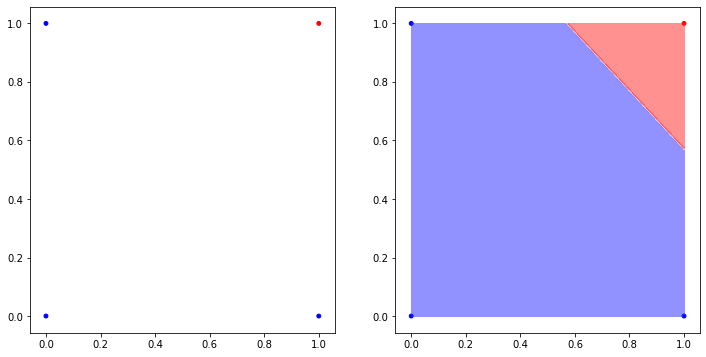

In [84]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [85]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 loss_train: 0.80520663 + 0.00000000 = 0.80520663 loss_val: 0.80520663
epoch: 1000/5000 loss_train: 0.00181963 + 0.00000000 = 0.00181963 loss_val: 0.00181963
epoch: 2000/5000 loss_train: 0.00084484 + 0.00000000 = 0.00084484 loss_val: 0.00084484
epoch: 3000/5000 loss_train: 0.00054536 + 0.00000000 = 0.00054536 loss_val: 0.00054536
epoch: 4000/5000 loss_train: 0.00040065 + 0.00000000 = 0.00040065 loss_val: 0.00040065
epoch: 5000/5000 loss_train: 0.00031574 + 0.00000000 = 0.00031574 loss_val: 0.00031574
Predições:
[[9.48663892e-05]
 [9.99929503e-01]
 [9.99024074e-01]
 [1.21184551e-04]]
Acurácia: 100.00%


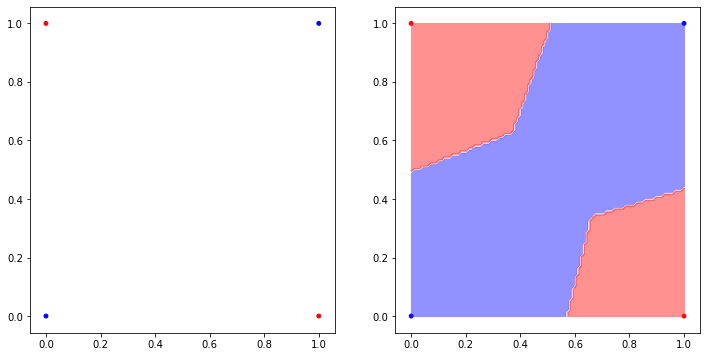

In [90]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


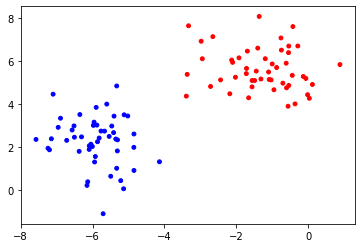

In [91]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/10000 loss_train: 0.57185932 + 0.00000000 = 0.57185932 loss_val: 0.57185932
epoch: 1000/10000 loss_train: 0.52246931 + 0.00000000 = 0.52246931 loss_val: 0.52246931
epoch: 2000/10000 loss_train: 0.51527446 + 0.00000000 = 0.51527446 loss_val: 0.51527446
epoch: 3000/10000 loss_train: 0.51202412 + 0.00000000 = 0.51202412 loss_val: 0.51202412
epoch: 4000/10000 loss_train: 0.51007307 + 0.00000000 = 0.51007307 loss_val: 0.51007307
epoch: 5000/10000 loss_train: 0.50879551 + 0.00000000 = 0.50879551 loss_val: 0.50879551
epoch: 6000/10000 loss_train: 0.50789637 + 0.00000000 = 0.50789637 loss_val: 0.50789637
epoch: 7000/10000 loss_train: 0.50722320 + 0.00000000 = 0.50722320 loss_val: 0.50722320
epoch: 8000/10000 loss_train: 0.50669971 + 0.00000000 = 0.50669971 loss_val: 0.50669971
epoch: 9000/10000 loss_train: 0.50628574 + 0.00000000 = 0.50628574 loss_val: 0.50628574
epoch: 10000/10000 loss_train: 0.50595544 + 0.00000000 = 0.50595544 loss_val: 0.50595544
Acurácia: 100.00%


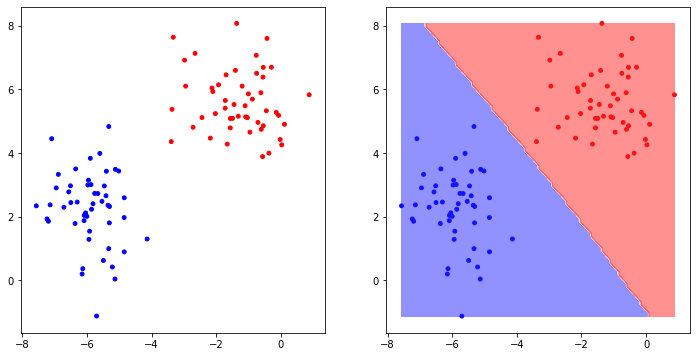

In [131]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


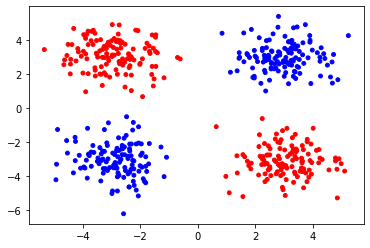

In [132]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/500 loss_train: 3.05303808 + 0.00000000 = 3.05303808 loss_val: 3.05303808
epoch:  100/500 loss_train: 0.06773710 + 0.00000000 = 0.06773710 loss_val: 0.06773710
epoch:  200/500 loss_train: 0.03455740 + 0.00000000 = 0.03455740 loss_val: 0.03455740
epoch:  300/500 loss_train: 0.02474510 + 0.00000000 = 0.02474510 loss_val: 0.02474510
epoch:  400/500 loss_train: 0.01952116 + 0.00000000 = 0.01952116 loss_val: 0.01952116
epoch:  500/500 loss_train: 0.01614768 + 0.00000000 = 0.01614768 loss_val: 0.01614768
Acurácia: 100.00%


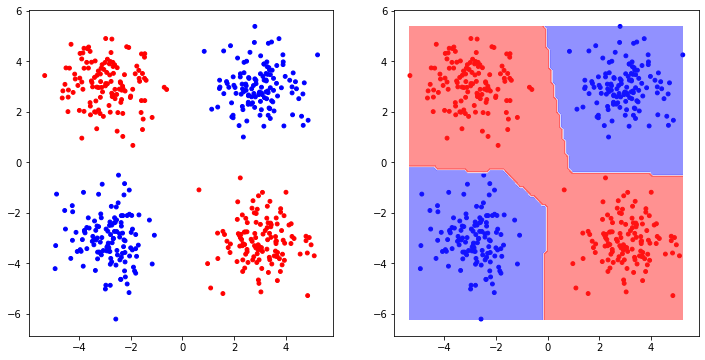

In [140]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


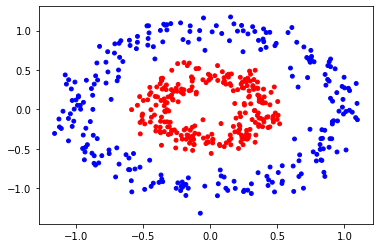

In [141]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.88530279 + 0.00000000 = 0.88530279 loss_val: 0.88530279
epoch:  100/1000 loss_train: 0.46416657 + 0.00000000 = 0.46416657 loss_val: 0.46416657
epoch:  200/1000 loss_train: 0.28499529 + 0.00000000 = 0.28499529 loss_val: 0.28499529
epoch:  300/1000 loss_train: 0.15289493 + 0.00000000 = 0.15289493 loss_val: 0.15289493
epoch:  400/1000 loss_train: 0.08146234 + 0.00000000 = 0.08146234 loss_val: 0.08146234
epoch:  500/1000 loss_train: 0.05196329 + 0.00000000 = 0.05196329 loss_val: 0.05196329
epoch:  600/1000 loss_train: 0.03806126 + 0.00000000 = 0.03806126 loss_val: 0.03806126
epoch:  700/1000 loss_train: 0.03013101 + 0.00000000 = 0.03013101 loss_val: 0.03013101
epoch:  800/1000 loss_train: 0.02480897 + 0.00000000 = 0.02480897 loss_val: 0.02480897
epoch:  900/1000 loss_train: 0.02112004 + 0.00000000 = 0.02112004 loss_val: 0.02112004
epoch: 1000/1000 loss_train: 0.01842149 + 0.00000000 = 0.01842149 loss_val: 0.01842149
Acurácia: 100.00%


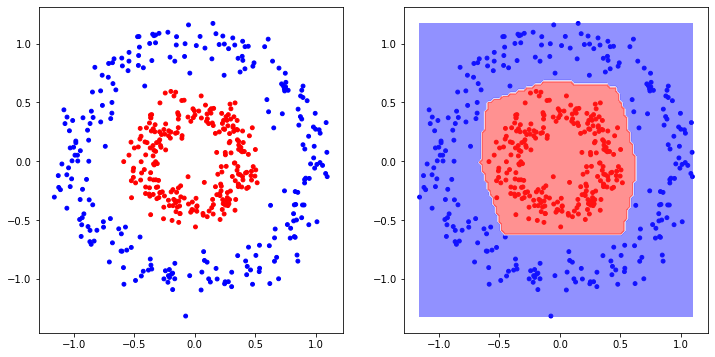

In [142]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=0.01, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


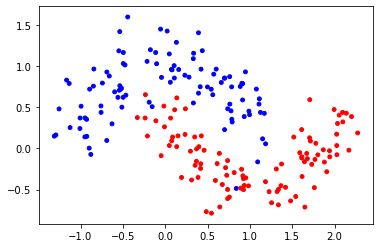

In [143]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss_train: 1.89030201 + 0.00000000 = 1.89030201 loss_val: 1.89030201
epoch:  200/2000 loss_train: 0.29844901 + 0.00000000 = 0.29844901 loss_val: 0.29844901
epoch:  400/2000 loss_train: 0.24502958 + 0.00000000 = 0.24502958 loss_val: 0.24502958
epoch:  600/2000 loss_train: 0.21774596 + 0.00000000 = 0.21774596 loss_val: 0.21774596
epoch:  800/2000 loss_train: 0.19491509 + 0.00000000 = 0.19491509 loss_val: 0.19491509
epoch: 1000/2000 loss_train: 0.17534254 + 0.00000000 = 0.17534254 loss_val: 0.17534254
epoch: 1200/2000 loss_train: 0.15897786 + 0.00000000 = 0.15897786 loss_val: 0.15897786
epoch: 1400/2000 loss_train: 0.14549117 + 0.00000000 = 0.14549117 loss_val: 0.14549117
epoch: 1600/2000 loss_train: 0.13441505 + 0.00000000 = 0.13441505 loss_val: 0.13441505
epoch: 1800/2000 loss_train: 0.12529993 + 0.00000000 = 0.12529993 loss_val: 0.12529993
epoch: 2000/2000 loss_train: 0.11776759 + 0.00000000 = 0.11776759 loss_val: 0.11776759
Acurácia: 96.00%


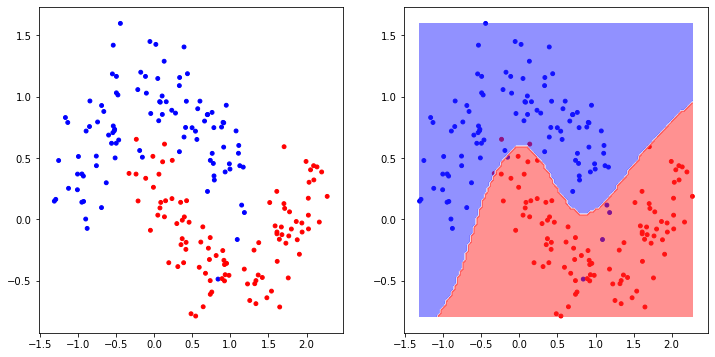

In [144]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


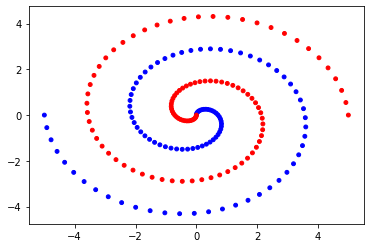

In [145]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 0.88604839 + 0.00000000 = 0.88604839 loss_val: 0.88604839
epoch:  500/5000 loss_train: 0.27627530 + 0.00000000 = 0.27627530 loss_val: 0.27627530
epoch: 1000/5000 loss_train: 0.11486355 + 0.00000000 = 0.11486355 loss_val: 0.11486355
epoch: 1500/5000 loss_train: 0.06168250 + 0.00000000 = 0.06168250 loss_val: 0.06168250
epoch: 2000/5000 loss_train: 0.04271451 + 0.00000000 = 0.04271451 loss_val: 0.04271451
epoch: 2500/5000 loss_train: 0.03262850 + 0.00000000 = 0.03262850 loss_val: 0.03262850
epoch: 3000/5000 loss_train: 0.02682487 + 0.00000000 = 0.02682487 loss_val: 0.02682487
epoch: 3500/5000 loss_train: 0.02308364 + 0.00000000 = 0.02308364 loss_val: 0.02308364
epoch: 4000/5000 loss_train: 0.02047429 + 0.00000000 = 0.02047429 loss_val: 0.02047429
epoch: 4500/5000 loss_train: 0.01855290 + 0.00000000 = 0.01855290 loss_val: 0.01855290
epoch: 5000/5000 loss_train: 0.01708328 + 0.00000000 = 0.01708328 loss_val: 0.01708328
Acurácia: 99.50%


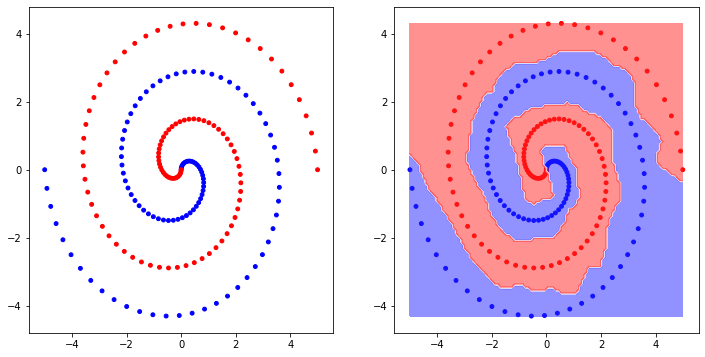

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


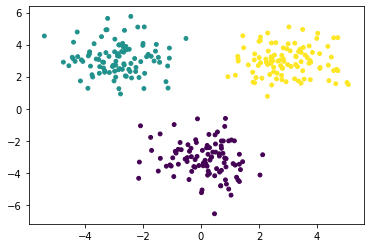

In [146]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [147]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 1.67014549 + 0.00379151 = 1.67393699 loss_val: 1.67014549
epoch:  100/1000 loss_train: 0.30451750 + 0.00389386 = 0.30841136 loss_val: 0.30451750
epoch:  200/1000 loss_train: 0.25072240 + 0.00394240 = 0.25466480 loss_val: 0.25072240
epoch:  300/1000 loss_train: 0.20976003 + 0.00397730 = 0.21373733 loss_val: 0.20976003
epoch:  400/1000 loss_train: 0.17790222 + 0.00400583 = 0.18190805 loss_val: 0.17790222
epoch:  500/1000 loss_train: 0.15290297 + 0.00402997 = 0.15693294 loss_val: 0.15290297
epoch:  600/1000 loss_train: 0.13307019 + 0.00405066 = 0.13712085 loss_val: 0.13307019
epoch:  700/1000 loss_train: 0.11714114 + 0.00406850 = 0.12120965 loss_val: 0.11714114
epoch:  800/1000 loss_train: 0.10418170 + 0.00408402 = 0.10826573 loss_val: 0.10418170
epoch:  900/1000 loss_train: 0.09350671 + 0.00409749 = 0.09760420 loss_val: 0.09350671
epoch: 1000/1000 loss_train: 0.08460882 + 0.00410918 = 0.08871800 loss_val: 0.08460882
[[ 0.25448282 -1.27382038]
 [ 1.66901461 -0

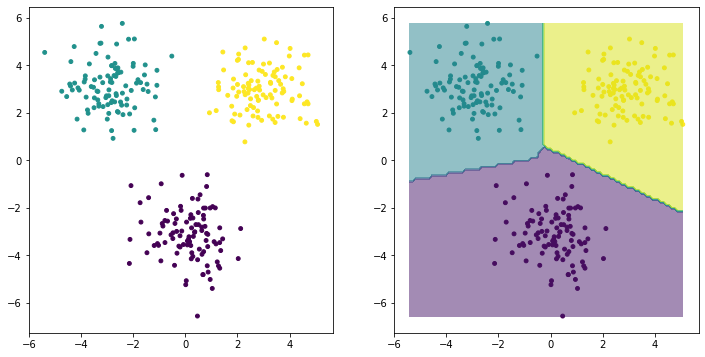

In [148]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


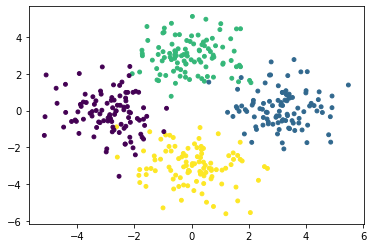

In [149]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [150]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 3.71087793 + 0.00000000 = 3.71087793 loss_val: 3.71087793
epoch:  100/1000 loss_train: 0.40976137 + 0.00000000 = 0.40976137 loss_val: 0.40976137
epoch:  200/1000 loss_train: 0.27419376 + 0.00000000 = 0.27419376 loss_val: 0.27419376
epoch:  300/1000 loss_train: 0.12024296 + 0.00000000 = 0.12024296 loss_val: 0.12024296
epoch:  400/1000 loss_train: 0.10045902 + 0.00000000 = 0.10045902 loss_val: 0.10045902
epoch:  500/1000 loss_train: 0.09509324 + 0.00000000 = 0.09509324 loss_val: 0.09509324
epoch:  600/1000 loss_train: 0.09229093 + 0.00000000 = 0.09229093 loss_val: 0.09229093
epoch:  700/1000 loss_train: 0.09044491 + 0.00000000 = 0.09044491 loss_val: 0.09044491
epoch:  800/1000 loss_train: 0.08911054 + 0.00000000 = 0.08911054 loss_val: 0.08911054
epoch:  900/1000 loss_train: 0.08808265 + 0.00000000 = 0.08808265 loss_val: 0.08808265
epoch: 1000/1000 loss_train: 0.08726626 + 0.00000000 = 0.08726626 loss_val: 0.08726626
Acurácia: 96.75%


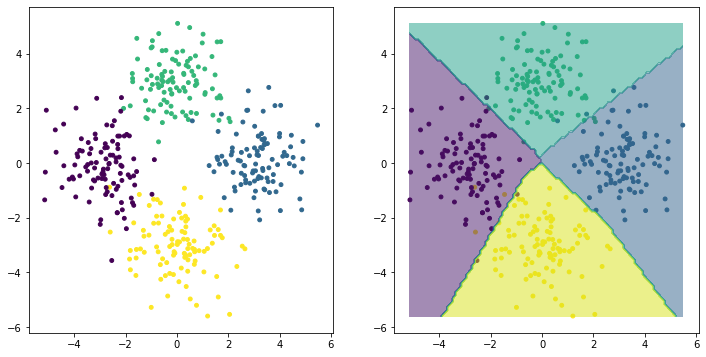

In [151]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


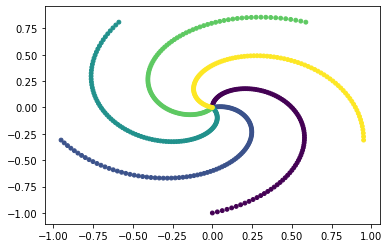

In [152]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [153]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 8.92891843 + 0.00000000 = 8.92891843 loss_val: 8.92891843
epoch:  100/1000 loss_train: 0.85775706 + 0.00000000 = 0.85775706 loss_val: 0.85775706
epoch:  200/1000 loss_train: 0.42627357 + 0.00000000 = 0.42627357 loss_val: 0.42627357
epoch:  300/1000 loss_train: 0.26185563 + 0.00000000 = 0.26185563 loss_val: 0.26185563
epoch:  400/1000 loss_train: 0.17476029 + 0.00000000 = 0.17476029 loss_val: 0.17476029
epoch:  500/1000 loss_train: 0.13313979 + 0.00000000 = 0.13313979 loss_val: 0.13313979
epoch:  600/1000 loss_train: 0.11103702 + 0.00000000 = 0.11103702 loss_val: 0.11103702
epoch:  700/1000 loss_train: 0.09391410 + 0.00000000 = 0.09391410 loss_val: 0.09391410
epoch:  800/1000 loss_train: 0.08502032 + 0.00000000 = 0.08502032 loss_val: 0.08502032
epoch:  900/1000 loss_train: 0.07726693 + 0.00000000 = 0.07726693 loss_val: 0.07726693
epoch: 1000/1000 loss_train: 0.07000527 + 0.00000000 = 0.07000527 loss_val: 0.07000527
Acurácia: 98.60%


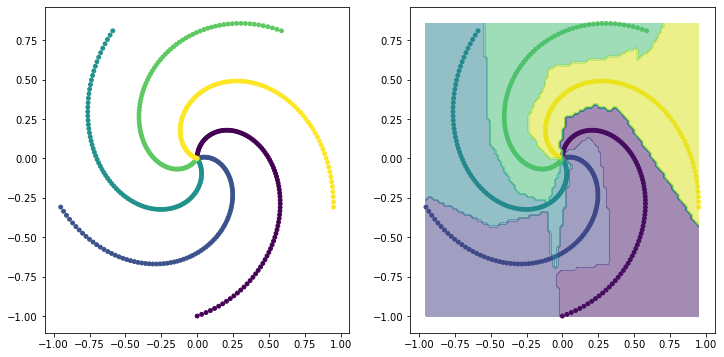

In [154]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


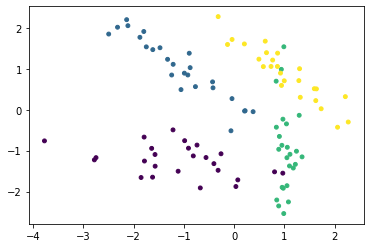

In [155]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, 
random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [156]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 4.58980407 + 0.00000000 = 4.58980407 loss_val: 4.58980407
epoch:  100/1000 loss_train: 0.34929683 + 0.00000000 = 0.34929683 loss_val: 0.34929683
epoch:  200/1000 loss_train: 0.29610081 + 0.00000000 = 0.29610081 loss_val: 0.29610081
epoch:  300/1000 loss_train: 0.27002452 + 0.00000000 = 0.27002452 loss_val: 0.27002452
epoch:  400/1000 loss_train: 0.25479933 + 0.00000000 = 0.25479933 loss_val: 0.25479933
epoch:  500/1000 loss_train: 0.24355001 + 0.00000000 = 0.24355001 loss_val: 0.24355001
epoch:  600/1000 loss_train: 0.23438675 + 0.00000000 = 0.23438675 loss_val: 0.23438675
epoch:  700/1000 loss_train: 0.22659253 + 0.00000000 = 0.22659253 loss_val: 0.22659253
epoch:  800/1000 loss_train: 0.21980893 + 0.00000000 = 0.21980893 loss_val: 0.21980893
epoch:  900/1000 loss_train: 0.21381335 + 0.00000000 = 0.21381335 loss_val: 0.21381335
epoch: 1000/1000 loss_train: 0.20848616 + 0.00000000 = 0.20848616 loss_val: 0.20848616
Acurácia: 94.00%


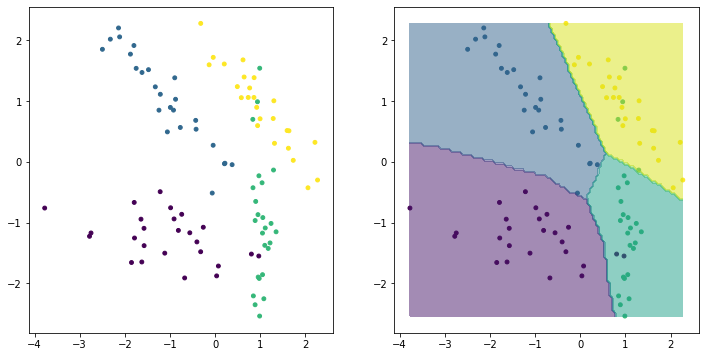

In [157]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


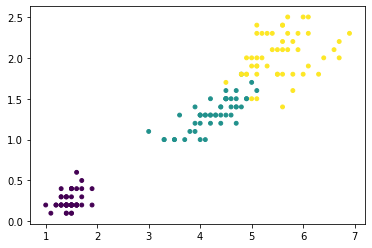

In [158]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [159]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/5000 loss_train: 4.00551079 + 0.00000000 = 4.00551079 loss_val: 4.00551079
epoch:  500/5000 loss_train: 0.18241050 + 0.00000000 = 0.18241050 loss_val: 0.18241050
epoch: 1000/5000 loss_train: 0.13420775 + 0.00000000 = 0.13420775 loss_val: 0.13420775
epoch: 1500/5000 loss_train: 0.11168335 + 0.00000000 = 0.11168335 loss_val: 0.11168335
epoch: 2000/5000 loss_train: 0.09915000 + 0.00000000 = 0.09915000 loss_val: 0.09915000
epoch: 2500/5000 loss_train: 0.09135816 + 0.00000000 = 0.09135816 loss_val: 0.09135816
epoch: 3000/5000 loss_train: 0.08612095 + 0.00000000 = 0.08612095 loss_val: 0.08612095
epoch: 3500/5000 loss_train: 0.08241974 + 0.00000000 = 0.08241974 loss_val: 0.08241974
epoch: 4000/5000 loss_train: 0.07970695 + 0.00000000 = 0.07970695 loss_val: 0.07970695
epoch: 4500/5000 loss_train: 0.07766089 + 0.00000000 = 0.07766089 loss_val: 0.07766089
epoch: 5000/5000 loss_train: 0.07608380 + 0.00000000 = 0.07608380 loss_val: 0.07608380
Acurácia: 96.00%


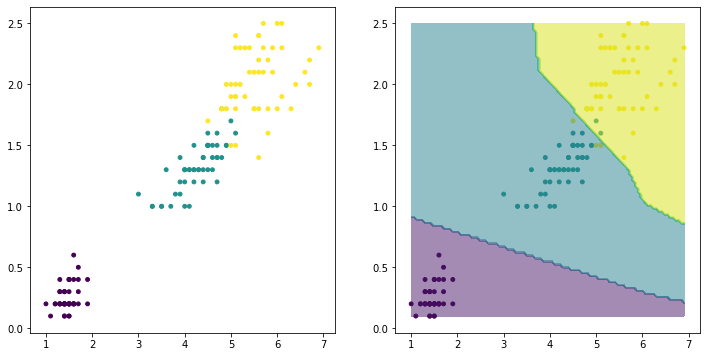

In [160]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=500)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.